**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on December 30th, 2021

In [1]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm

In [4]:
%load_ext autoreload
%autoreload 2
from socceraction.data.wyscout import PublicWyscoutLoader
import socceraction.spadl as spadl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up the StatsBombLoader

In [5]:
# Use this if you want to use the free public statsbomb data
# or provide credentials to access the API
WSL = PublicWyscoutLoader()

In [6]:
# View all available competitions
competitions = WSL.competitions()
set(competitions.competition_name)

{'English first division',
 'European Championship',
 'French first division',
 'German first division',
 'Italian first division',
 'Spanish first division',
 'World Cup'}

In [44]:
# Fifa world cup
competition_name = 'English first division'
selected_competitions = competitions[competitions.competition_name == competition_name]

# # Messi data
# selected_competitions = competitions[competitions.competition_name == "La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name == "FA Women's Super League"]

selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
1,364,181150,England,English first division,male,2017/2018


In [45]:
# Get games from all selected competitions
games = pd.concat([
    WSL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
# games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

## Load and convert match data

In [46]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(WSL.teams(game.game_id))
    players.append(WSL.players(game.game_id))
    events = WSL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.wyscout.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data:   1%|▏         | 5/380 [00:02<03:03,  2.04it/s]


KeyboardInterrupt: 

## Store converted spadl data in a h5-file

In [42]:
datafolder = "../Data/wyscout-v2"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-wyscout-v2.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

In [54]:

with pd.HDFStore(spadl_h5) as spadlstore:
    game_example = spadlstore[f"actions/game_2500091"]

In [55]:
game_example

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id
0,2500091,1,2.398714,1673,8290,52.50,33.32,37.80,34.00,251665472,0,0,1,0
1,2500091,1,3.524132,1673,8897,37.80,34.00,30.45,17.68,251665473,0,0,1,1
2,2500091,1,4.953577,1673,55979,30.45,17.68,42.00,18.36,251665479,0,0,1,2
3,2500091,1,7.805655,1673,9419,42.00,18.36,70.35,63.92,251665474,0,0,1,3
4,2500091,1,12.560241,1673,14796,70.35,63.92,43.05,51.68,251665476,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,2500091,2,2844.418845,1673,62389,81.90,65.96,96.60,33.32,251666355,0,3,1,1297
1298,2500091,2,2847.558375,1673,38377,97.65,34.00,105.00,34.00,251666357,3,11,0,1298
1299,2500091,2,2850.783261,1609,25662,105.00,34.00,105.00,34.00,251665469,2,14,1,1299
1300,2500091,2,2853.426584,1673,55979,102.90,35.36,102.90,35.36,251666359,0,8,1,1300


## Plot the spadl data
Extra library required: ```pip install matplotsoccer```

In [47]:
games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,2500089,364,181150,2018-05-13 14:00:00,38,1646,1659
1,2500090,364,181150,2018-05-13 14:00:00,38,1628,1627
2,2500091,364,181150,2018-05-13 14:00:00,38,1673,1609
3,2500092,364,181150,2018-05-13 14:00:00,38,1612,1651
4,2500093,364,181150,2018-05-13 14:00:00,38,1611,1644
...,...,...,...,...,...,...,...
375,2499723,364,181150,2017-08-12 14:00:00,1,1623,1639
376,2499726,364,181150,2017-08-12 14:00:00,1,1619,10531
377,2499728,364,181150,2017-08-12 14:00:00,1,1627,1659
378,2499727,364,181150,2017-08-12 11:30:00,1,1644,1612


In [50]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == competition_name) 
                  & (games.away_team_name == "Arsenal FC")
                  & (games.home_team_name == "Huddersfield Town FC")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']
actions[:5]

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name,team_name_short,team_name
0,2500091,1,2.398714,1673,8290,52.50,33.32,37.80,34.00,251665472,0,0,1,0,pass,success,foot,A. Pritchard,Huddersfield Town,Huddersfield Town FC
1,2500091,1,3.524132,1673,8897,37.80,34.00,30.45,17.68,251665473,0,0,1,1,pass,success,foot,J. Hogg,Huddersfield Town,Huddersfield Town FC
2,2500091,1,4.953577,1673,55979,30.45,17.68,42.00,18.36,251665479,0,0,1,2,pass,success,foot,M. Jørgensen,Huddersfield Town,Huddersfield Town FC
3,2500091,1,7.805655,1673,9419,42.00,18.36,70.35,63.92,251665474,0,0,1,3,pass,success,foot,T. Ince,Huddersfield Town,Huddersfield Town FC
4,2500091,1,12.560241,1673,14796,70.35,63.92,43.05,51.68,251665476,0,0,1,4,pass,success,foot,C. Löwe,Huddersfield Town,Huddersfield Town FC


In [51]:
actions.loc[actions['type_name'] == "shot"]

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name,team_name_short,team_name
35,2500091,1,168.388255,1673,214654,95.55,37.40,105.00,34.0000,251665504,3,11,0,35,shot,fail,head/other,S. Mounié,Huddersfield Town,Huddersfield Town FC
52,2500091,1,218.814783,1609,7870,21.00,19.04,0.00,37.4000,251664373,0,11,0,52,shot,fail,foot,A. Ramsey,Arsenal,Arsenal FC
60,2500091,1,288.583578,1673,132,98.70,38.08,105.00,40.8000,251665520,0,11,0,60,shot,fail,foot,T. Kongolo,Huddersfield Town,Huddersfield Town FC
62,2500091,1,291.366261,1673,15215,100.80,36.72,100.80,36.7200,251665521,0,11,0,62,shot,fail,foot,C. Schindler,Huddersfield Town,Huddersfield Town FC
140,2500091,1,639.759842,1673,214654,95.55,31.96,105.00,40.8000,251665574,0,11,0,140,shot,fail,foot,S. Mounié,Huddersfield Town,Huddersfield Town FC
182,2500091,1,784.221321,1673,214654,91.35,44.88,105.00,40.8000,251665613,0,11,0,182,shot,fail,foot,S. Mounié,Huddersfield Town,Huddersfield Town FC
266,2500091,1,1123.323660,1609,7870,23.10,34.68,0.00,27.2000,251664550,0,11,0,266,shot,fail,foot,A. Ramsey,Arsenal,Arsenal FC
361,2500091,1,1569.974290,1609,14869,5.25,31.28,0.00,27.2000,251664651,0,11,0,361,shot,fail,foot,S. Kolašinac,Arsenal,Arsenal FC
366,2500091,1,1638.172246,1673,8290,90.30,34.68,105.00,40.8000,251665731,3,11,0,366,shot,fail,head/other,A. Pritchard,Huddersfield Town,Huddersfield Town FC
399,2500091,1,1766.219988,1609,105338,17.85,36.04,17.85,36.0400,251664691,0,11,0,399,shot,fail,foot,H. Mkhitaryan,Arsenal,Arsenal FC


2018-05-13 14:00:00 Huddersfield Town FC vs Arsenal FC 38'


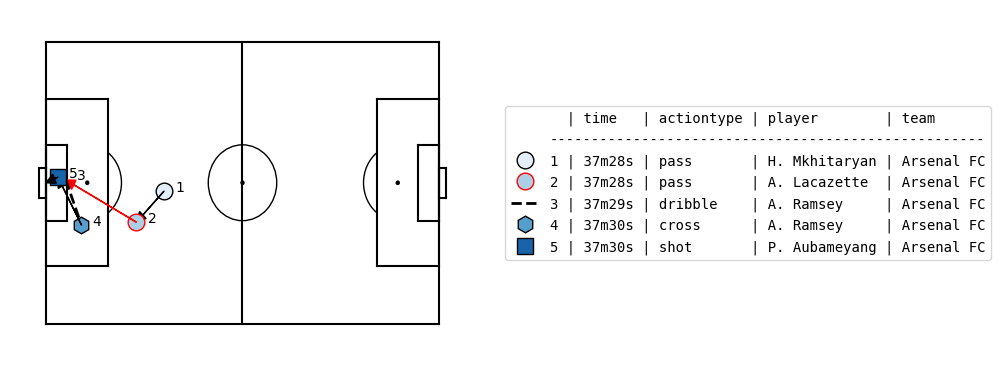

In [52]:
import matplotsoccer

# Select the 5 actions preceding the 2-0
shot = 505
a = actions[shot-4:shot+1].copy()

# Print the game date and timestamp of the goal
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} vs {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)